# Flight Research and Analytics EDA

## Setup:

In [3]:
import boto3
import sagemaker
%matplotlib inline
%config InlineBackend.figure_format='retina'
#from pyathena import connect
import pandas as pd
import numpy as np

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [84]:
!aws s3 ls s3://508-team4/data/

2023-03-17 04:58:12          0 
2023-03-19 18:54:11  127987645 la_compensation.csv
2023-03-19 18:54:11  186188464 sf_compensation.csv
2023-03-19 18:54:13     802519 sj_compensation_2013.csv
2023-03-19 18:54:16     905397 sj_compensation_2014.csv
2023-03-19 18:54:18     964227 sj_compensation_2015.csv
2023-03-19 18:54:19     965656 sj_compensation_2016.csv
2023-03-19 18:54:21    1055695 sj_compensation_2017.csv
2023-03-19 18:54:22    1008253 sj_compensation_2018.csv
2023-03-19 18:54:23    1054198 sj_compensation_2019.csv
2023-03-19 18:54:24    1026127 sj_compensation_2020.csv
2023-03-19 18:54:26    1033928 sj_compensation_2021.csv


In [88]:
Uyen_df= pd.read_csv("s3://508-team4/data/sj_compensation_2013.csv")
Uyen_df.head()

,NAME,Department Name,Job Title,Total Cash Compensation,Base Pay,Overtime,Sick and Vacation Payouts,Other Cash Compensation,Deferred Comp Paid by Employer,Medical Dental Vision City Paid,Employer's Share Pension Payments,Retired?
0,"Bustillos,Steven D",Police,Police Sergeant,286137.69,90888.00,89867.88,"97,969.79","7,412.02",NaN,"13,640.50","74,429.71",Yes
1,"Figone,Debra J",City Manager,City Manager U,248564.84,227975.02,NaN,NaN,"20,589.82","20,517.64","15,166.00","131,032.44",Yes
2,"Guerra,Daniel P",Police,Police Officer,241039.12,97198.40,132104.54,NaN,"11,736.18",NaN,"15,371.56","79,821.51",No
3,"Moore,Christopher M",Police,Chief Of Police U,233540.32,15319.54,NaN,"215,470.80","2,749.98",NaN,"1,371.81","11,204.16",Yes
4,"Vasquez,Hector M",Police,Police Officer,230469.85,97198.40,124552.69,NaN,"8,718.76",NaN,"16,345.32","79,821.51",No


## Setup Athena:

In [4]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [5]:
from pyathena import connect

In [6]:
ingest_create_athena_db_passed = False

In [7]:
%store -r ingest_create_athena_table_parquet_passed

In [8]:
database_name = 'flight_analysis'
table_name = 'cancellation_codes_4'

In [9]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [10]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

### Create Database:

In [9]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS flight_analysis


""


In [10]:
cancellation_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table'

### Create Cancellation Codes Table:

In [11]:
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, cancellation_s3
)

In [12]:
pd.read_sql(statement, conn)

""


Verify the table was created by way of a Query:

In [13]:
query = "SELECT * FROM {}.{}".format(database_name, table_name)
pd.read_sql(query, conn)

,index,code,description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


In [15]:
airlineID_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airlineID_carrier_table'
flights_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table'
weather_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016'
customer_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/Airline_Customer_Service'
airportCodes_s3 = 's3://sagemaker-us-east-1-993410942383/content-project/airline_data/airport_codes_table'

In [191]:
table_name_airportCodes = 'airport_codes_table'
table_name_airlineID = 'airlineID_table'
table_name_customer = 'customer_service_table2'
table_name_flights = 'flights_table_21'
table_weather = 'weather_table'

### Flights Table:

In [158]:
statement_flights = """CREATE EXTERNAL TABLE {}.{}(
         Index string,
         Year	int,
         Quarter	int,
         Month 	int,
         DayofMonth 	int,
         DayOfWeek 	int,
         FlightDate 	string,
         UniqueCarrier 	string,
         AirlineID	int,
         Carrier	string,
         TailNum	string,
         FlightNum	int,
         OriginAirportID	int,
         OriginAirportSeqID	int,
         OriginCityMarketID	int,
         Origin	string,
         OriginCityName	string,
         OriginState	string,
         OriginStateFips	int,
         OriginStateName	string,
         OriginWac	int,
         DestAirportID	int,
         DestAirportSeqID	int,
         DestCityMarketID	int,
         Dest	string,
         DestCityName	string,
         DestState	string,
         DestStateFips	int,
         DestStateName	string,
         DestWac	int,
         CRSDepTime	int,
         DepTime	string,
         DepDelay	string,
         DepDelayMinutes	string,
         DepDel15	string,
         DepartureDelayGroups	string,
         DepTimeBlk	string,
         TaxiOut	string,
         WheelsOff	string,
         WheelsOn	string,
         TaxiIn	string,
         CRSArrTime	string,
         ArrTime	string,
         ArrDelay	string,
         ArrDelayMinutes	string,
         ArrDel15	string,
         ArrivalDelayGroups	string,
         ArrTimeBlk	string,
         Cancelled	int,
         CancellationCode	string,
         Diverted	int,
         CRSElapsedTime	string,
         ActualElapsedTime	string,
         AirTime	string,
         Flights	string,
         Distance	string,
         DistanceGroup	int,
         CarrierDelay	string,
         WeatherDelay	string,
         NASDelay	string,
         SecurityDelay	string,
         LateAircraftDelay	string,
         FirstDepTime	string,
         TotalAddGTime	string,
         LongestAddGTime	string,
         DivAirportLandings	string,
         DivReachedDest	string,
         DivActualElapsedTime	string,
         DivArrDelay	string,
         DivDistance	string,
         Div1Airport	string,
         Div1AirportID	string,
         Div1AirportSeqID	string,
         Div1WheelsOn	string,
         Div1TotalGTime	string,
         Div1LongestGTime	string,
         Div1WheelsOff	string,
         Div1TailNum	string,
         Div2Airport	string,
         Div2AirportID	string,
         Div2AirportSeqID	string,
         Div2WheelsOn	string,
         Div2TotalGTime	string,
         Div2LongestGTime	string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_flights, flights_s3
)

In [159]:
pd.read_sql(statement_flights, conn)

""


In [122]:
query_flights = "SELECT Index, FlightDate, FlightNum, OriginAirportID, OriginAirportSeqID, OriginCityMarketID, Origin, OriginCityName, OriginState, OriginStateFips, OriginStateName, Dest FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_flights)
pd.read_sql(query_flights, conn)

,Index,FlightDate,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,Dest
0,0,2016-01-06,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
1,1,2016-01-07,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
2,10,2016-01-16,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,DTW
3,100,2016-01-13,45,12478,1247803,31703,JFK,"New York, NY",NY,36,New York,SEA
4,1000,2016-01-17,80,15376,1537602,30436,TUS,"Tucson, AZ",AZ,4,Arizona,DFW
5,10000,2016-01-14,271,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,MIA
6,100000,2016-01-18,2035,15024,1502403,34945,STT,"Charlotte Amalie, VI",VI,78,U.S. Virgin Islands,SJU
7,100001,2016-01-18,2036,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,BOS
8,100002,2016-01-18,2051,10721,1072102,30721,BOS,"Boston, MA",MA,25,Massachusetts,MCO
9,100003,2016-01-18,2054,14843,1484304,34819,SJU,"San Juan, PR",PR,72,Puerto Rico,FLL


In [160]:
query_flights2 = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_flights)
pd.read_sql(query_flights2, conn)

,index,year,quarter,month,dayofmonth,dayofweek,flightdate,uniquecarrier,airlineid,carrier,...,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,,,,,,,,,,
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,,,,,,,,,,
2,10,2016,1,1,16,6,2016-01-16,AA,19805,AA,...,,,,,,,,,,
3,100,2016,1,1,13,3,2016-01-13,AA,19805,AA,...,,,,,,,,,,
4,1000,2016,1,1,17,7,2016-01-17,AA,19805,AA,...,,,,,,,,,,
5,10000,2016,1,1,14,4,2016-01-14,AA,19805,AA,...,,,,,,,,,,
6,100000,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
7,100001,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
8,100002,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,
9,100003,2016,1,1,18,1,2016-01-18,B6,20409,B6,...,,,,,,,,,,


### Customer Service Table:

In [165]:
statement_customer = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Carrier string,
         Commitment string,
         Provided string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_customer, customer_s3
)

In [166]:
pd.read_sql(statement_customer, conn)

""


In [167]:
query_customer = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_customer)
pd.read_sql(query_customer, conn)

,index,carrier,commitment,provided
0,Alaska,Rebook on partner airline or another airline w...,1,None
1,Alaska,Complimentary hotel accommodations for any pas...,1,None
2,Alaska,Meal or meal cash/voucher when cancellation re...,1,None
3,Alaska,Rebook passenger on same airline at no additio...,1,None
4,Alaska,Complimentary ground transportation to and fro...,1,None
5,Allegiant,Complimentary ground transportation to and fro...,1,None
6,Allegiant,Rebook passenger on same airline at no additio...,1,None
7,Allegiant,Meal or meal cash/voucher when cancellation re...,0,None
8,Allegiant,Complimentary hotel accommodations for any pas...,1,None
9,Allegiant,Rebook on partner airline or another airline w...,0,None


### Ariline Carrier ID table:

In [169]:
statement_carrier = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airlineID, airlineID_s3
)

In [170]:
pd.read_sql(statement_carrier, conn)

""


In [171]:
query_carrier = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_airlineID)
pd.read_sql(query_carrier, conn)

,index,code,description
0,0,19031,Mackey International Inc.: MAC
1,1,19032,Munz Northern Airlines Inc.: XY
2,10,19041,Valdez Airlines: VEZ
3,100,19131,Birchwood Air Service: BIR
4,1000,20032,Air Europe S.P.A.: PE
5,1001,20033,UFS Inc.: U2
6,1002,20034,Pacific International Airlines: PIQ
7,1003,20035,Air Florida Express: AFE
8,1004,20036,American Flight Group: AFG
9,1005,20037,Aviation Sales: AVL


### Airport Codes Table:

In [172]:
statement_airportcode = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         Code string,
         Description string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_airportCodes, airportCodes_s3
)

In [173]:
pd.read_sql(statement_airportcode, conn)

""


In [174]:
query_airportcode = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_name_airportCodes)
pd.read_sql(query_airportcode, conn)

,index,code,description
0,0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10,1N7,"Blairstown, NJ: Blairstown Airport"
3,100,A93,"Bradley Lake Project, AK: Bradley Lake Project..."
4,1000,CGF,"Cleveland, OH: Cuyahoga County"
5,1001,CGH,"Sao Paulo, Brazil: Congonhas"
6,1002,CGI,"Cape Girardeau, MO: Cape Girardeau Regional"
7,1003,CGK,"Jakarta, Indonesia: Soekarno-Hatta International"
8,1004,CGM,"Camiguin, Philippines: Camiguin Airport"
9,1005,CGN,"Cologne, Germany: Koln Bonn"


### Weather Table:

In [192]:
statement_weather = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         Index string,
         EventId string,
         Type string,
         Severity string,
         StartTime string,
         EndTime string,
         Precipitation string,
         TimeZone string,
         AirportCode string,
         LocationLat string,
         LocationLng string,
         City string,
         County string,
         State string,
         ZipCode string
        
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '\,' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_weather, weather_s3
)

In [193]:
pd.read_sql(statement_weather, conn)

""


In [194]:
query_weather = "SELECT * FROM {}.{} ORDER BY Index asc LIMIT 10".format(database_name, table_weather)
pd.read_sql(query_weather, conn)

,index,eventid,type,severity,starttime,endtime,precipitation,timezone,airportcode,locationlat,locationlng,city,county,state,zipcode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,10,W-11,Cold,Severe,2016-01-09 16:54:00,2016-01-09 20:34:00,0.0,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,100,W-101,Snow,Light,2016-04-16 09:35:00,2016-04-16 10:15:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,1003621,W-1017246,Snow,Light,2016-01-04 12:15:00,2016-01-04 12:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
5,1003622,W-1017247,Snow,Light,2016-01-04 12:55:00,2016-01-04 13:55:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
6,1003623,W-1017248,Snow,Light,2016-01-04 14:15:00,2016-01-04 15:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
7,1003624,W-1017249,Snow,Light,2016-01-04 15:55:00,2016-01-04 16:15:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
8,1003625,W-1017250,Rain,Light,2016-01-08 13:55:00,2016-01-08 17:55:00,0.06,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0
9,1003626,W-1017251,Rain,Light,2016-01-08 18:15:00,2016-01-08 19:35:00,0.0,US/Eastern,KMKJ,36.8949,-81.3499,Rural Retreat,Smyth,VA,24368.0


## EDA Question: 

### How do the various airlines compare when it came to Reasons for Canceled Flights?

In [11]:
flights_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/airline_flights_table/arline_flights_table.csv")
flights_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016,1,1,8,5,2016-01-08,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016,1,1,9,6,2016-01-09,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016,1,1,10,7,2016-01-10,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
CancellationCode_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/cancellation_table/CancellationCode_table.csv")
CancellationCode_df.head()

,Unnamed: 0,Code,Description
0,0,A,Carrier
1,1,B,Weather
2,2,C,National Air System
3,3,D,Security


In [4]:
import seaborn as sns


[Text(0, 0, 'Carrier'),
 Text(0, 0, 'Weather'),
 Text(0, 0, 'National Air System')]

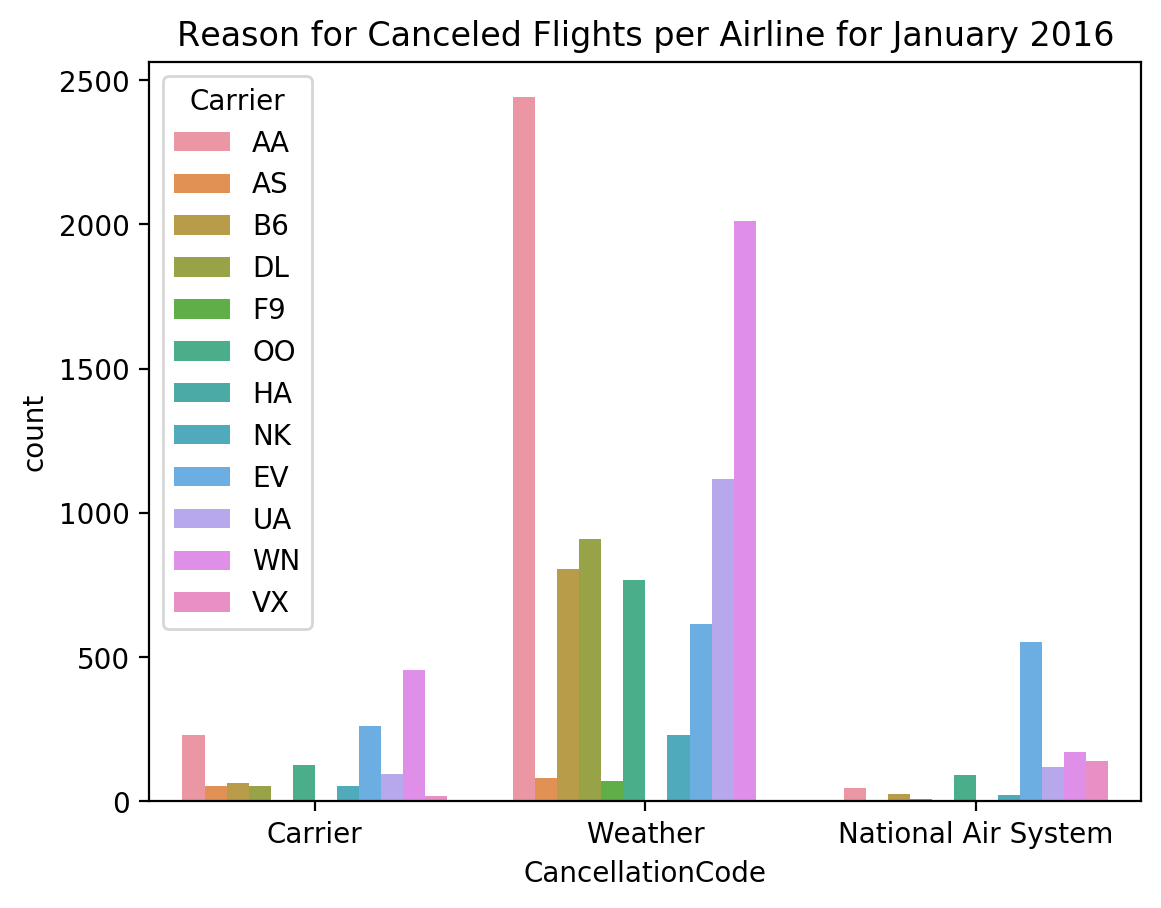

In [13]:
import seaborn as sns

g=sns.countplot(data=flights_df,
              x='CancellationCode',
              hue='Carrier'
             )
g.set_title('Reason for Canceled Flights per Airline for January 2016')
g.set_xticklabels(['Carrier','Weather','National Air System'])

Hawaiian Airlines and Frontier Airlines have the least cancellations for the month of January 2016 as they don't even show up for these cancellation reasons.

### How many flights per day were scheduled versus canceled?

In [14]:
#for index, row in flights_df.iterrows():
# Sum of canceled daily flights:
dff = flights_df.groupby(["FlightDate"]).Cancelled.sum().reset_index()
#dff.head()

# Sum of total number of flights (since Quarter is always 1):
dff2 = flights_df.groupby(["FlightDate"]).Quarter.count().reset_index()
dff2.rename(columns={'Quarter':'Total_no_Flights'}, inplace=True)
#dff2.head()

dff_flights=pd.merge(dff, dff2, on = "FlightDate")
dff_flights.head()
#flights_sum=flights_df['FlightDate'].groupby(flights_df['Cancelled'] == 1)

,FlightDate,Cancelled,Total_no_Flights
0,2016-01-01,57,13019
1,2016-01-02,52,14869
2,2016-01-03,97,15878
3,2016-01-04,87,15570
4,2016-01-05,204,14582


In [203]:
flights_sum.head()

0      2016-01-06
1      2016-01-07
2      2016-01-08
3      2016-01-09
4      2016-01-10
72     2016-01-16
79     2016-01-23
80     2016-01-24
81     2016-01-25
102    2016-01-15
Name: FlightDate, dtype: object

In [5]:
import matplotlib.pyplot as plt


[Text(0, 0, '01/01'),
 Text(0, 0, '01/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '01/04'),
 Text(0, 0, '01/05'),
 Text(0, 0, '01/06'),
 Text(0, 0, '01/07'),
 Text(0, 0, '01/08'),
 Text(0, 0, '01/09'),
 Text(0, 0, '01/10'),
 Text(0, 0, '01/11'),
 Text(0, 0, '01/12'),
 Text(0, 0, '01/13'),
 Text(0, 0, '01/14'),
 Text(0, 0, '01/15'),
 Text(0, 0, '01/16'),
 Text(0, 0, '01/17'),
 Text(0, 0, '01/18'),
 Text(0, 0, '01/19'),
 Text(0, 0, '01/20'),
 Text(0, 0, '01/21'),
 Text(0, 0, '01/22'),
 Text(0, 0, '01/23'),
 Text(0, 0, '01/24'),
 Text(0, 0, '01/25'),
 Text(0, 0, '01/26'),
 Text(0, 0, '01/27'),
 Text(0, 0, '01/28'),
 Text(0, 0, '01/29'),
 Text(0, 0, '01/30'),
 Text(0, 0, '01/31')]

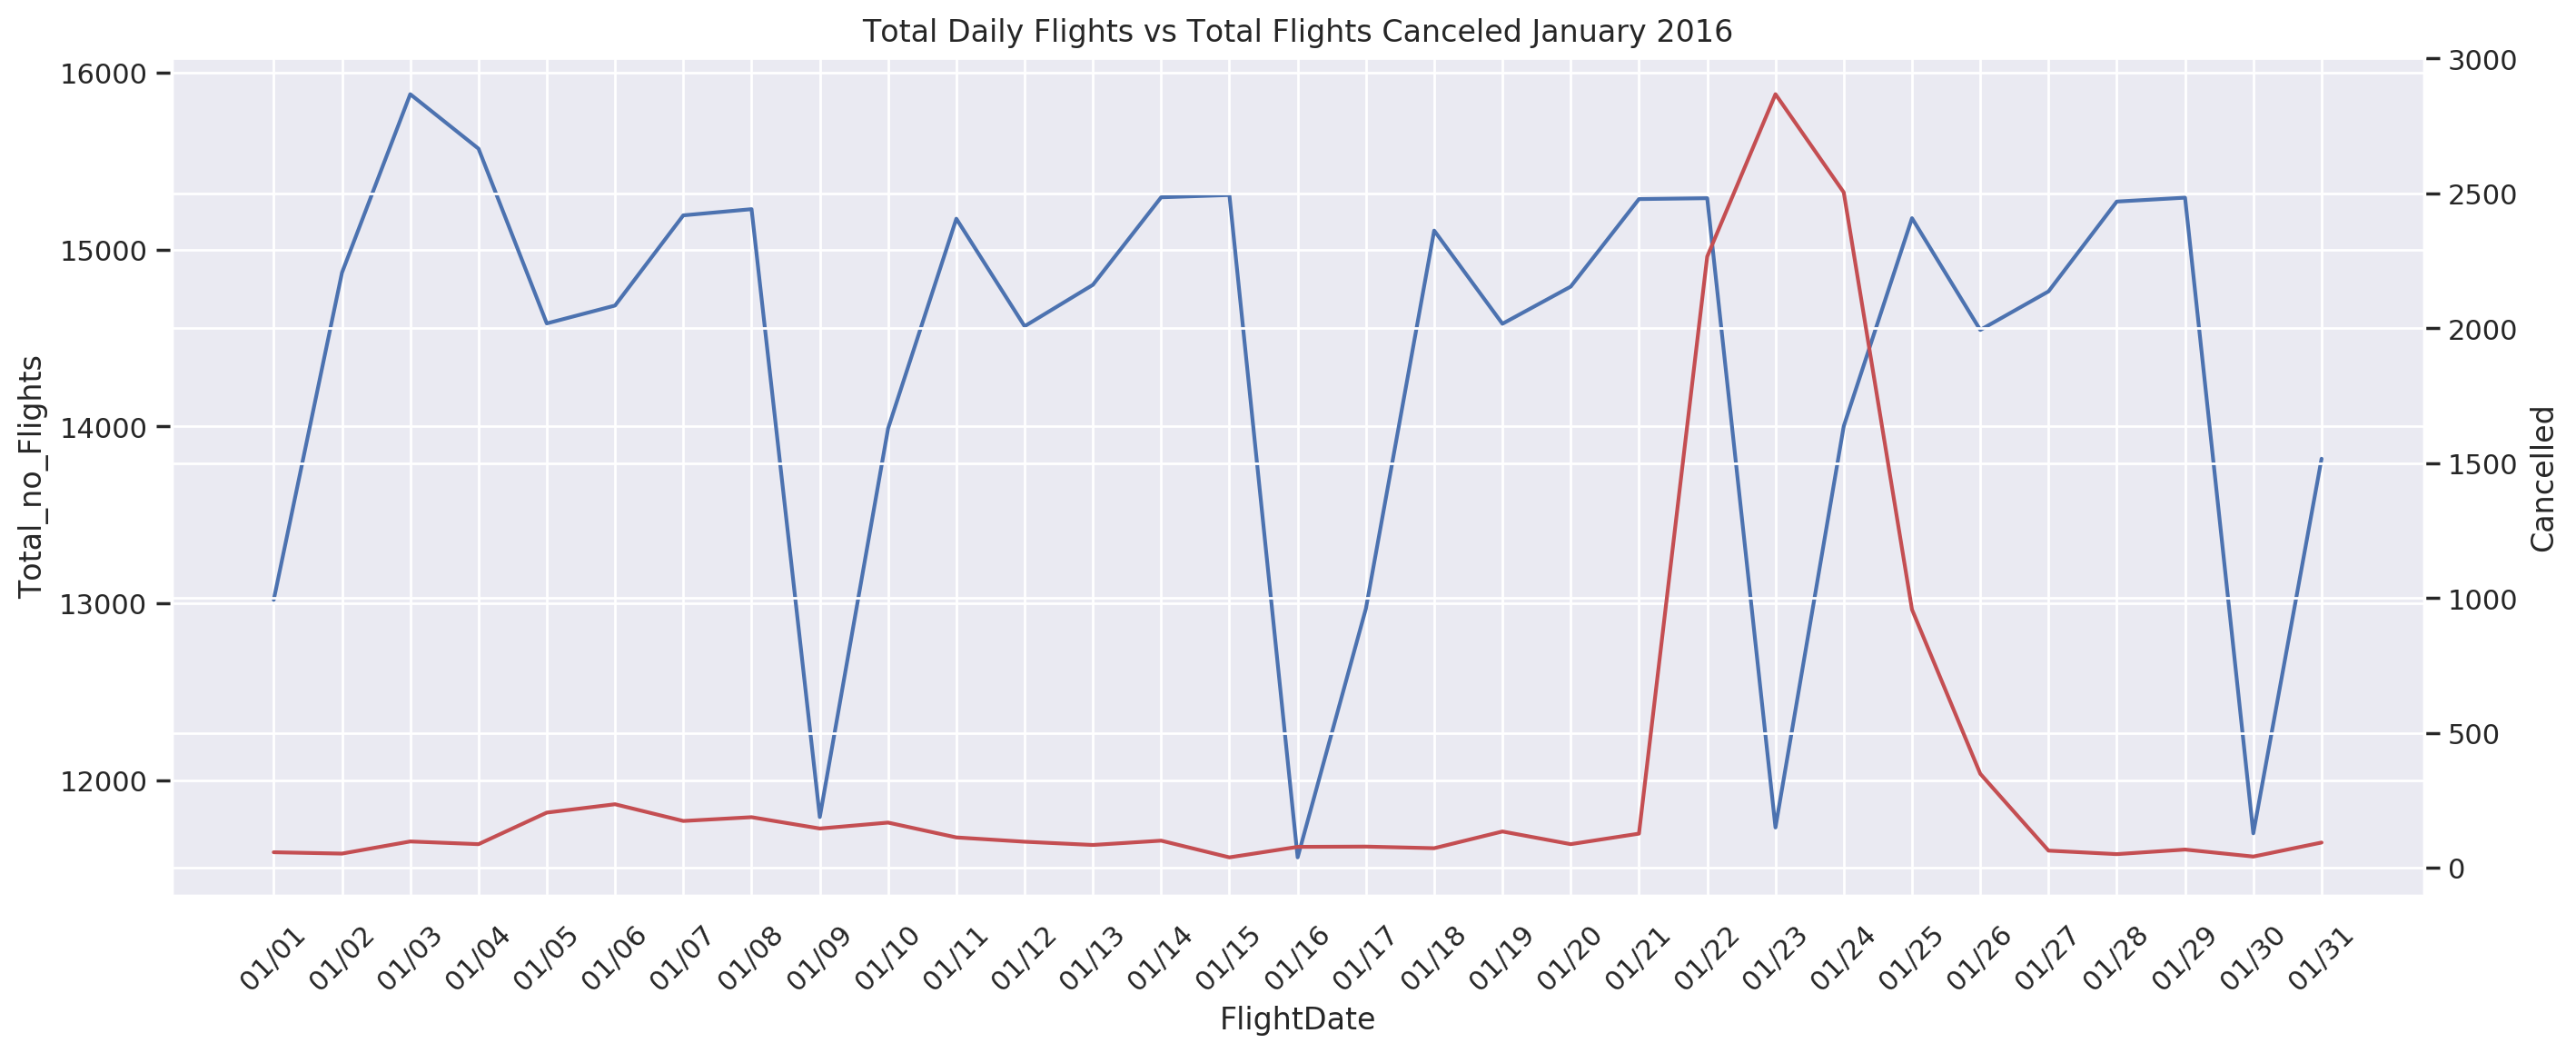

In [16]:
sns.set(rc={'figure.figsize':(10,7)})

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.set_title("Total Daily Flights vs Total Flights Canceled January 2016")
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

#ax2.set(ylim=(0, y2_limit))
g1 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Total_no_Flights", ax = ax1, color = 'b') # plots the first set
g2 = sns.lineplot(data = dff_flights, x = "FlightDate", y = "Cancelled", ax = ax2, color = 'r') # plots the second set 
#g3 = sns.lineplot(data = df, x = x1, y = y3, ax = ax3, color = y3_color)

#g_line = sns.lineplot(x="FlightDate", y="Total_no_Flights", data=dff_flights)
#g_line.add_lineplot(x="FlightDate",y="Cancelled",data=dff_flights)
g1.set_xticklabels(labels=["01/01","01/02","01/03","01/04","01/05",
                          "01/06","01/07","01/08","01/09","01/10","01/11",
                          "01/12","01/13","01/14","01/15","01/16","01/17",
                          "01/18","01/19","01/20","01/21","01/22","01/23",
                          "01/24","01/25","01/26","01/27","01/28","01/29",
                          "01/30","01/31"], rotation=45)
#g1.set_title("Total Daily Flights vs Total Flights Canceled January 2016")
##g.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])

Might be interesting to find out what happened between 01/20 and 01/27 of 2016 that caused the larger increase in canceled flights within the domestic US.

Keep in mind the double axis to keep both plots on top of one another, but the number of canceled flights is significantly smaller than the number of total flights scheduled for each day.

### Which airports had the most cancellations?

In [17]:
#for index, row in flights_df.iterrows():
# Sum of canceled daily flights:
dff_Origin_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().reset_index()
#dff.head()
dff_Dest_airportcode = flights_df.groupby(["Origin"]).Cancelled.sum().reset_index()


In [241]:
dff_Origin_airportcode.head()

,Origin,Cancelled
0,ABE,8
1,ABQ,12
2,ABR,0
3,ABY,0
4,ACT,0


In [18]:
dff_airportOrigin = dff_Origin_airportcode.sort_values(['Cancelled'], ascending=False)
dff_airportDest = dff_Dest_airportcode.sort_values(['Cancelled'], ascending=False)


Text(0.5, 1.0, 'Cancellations per domestic US airports for January 2016')

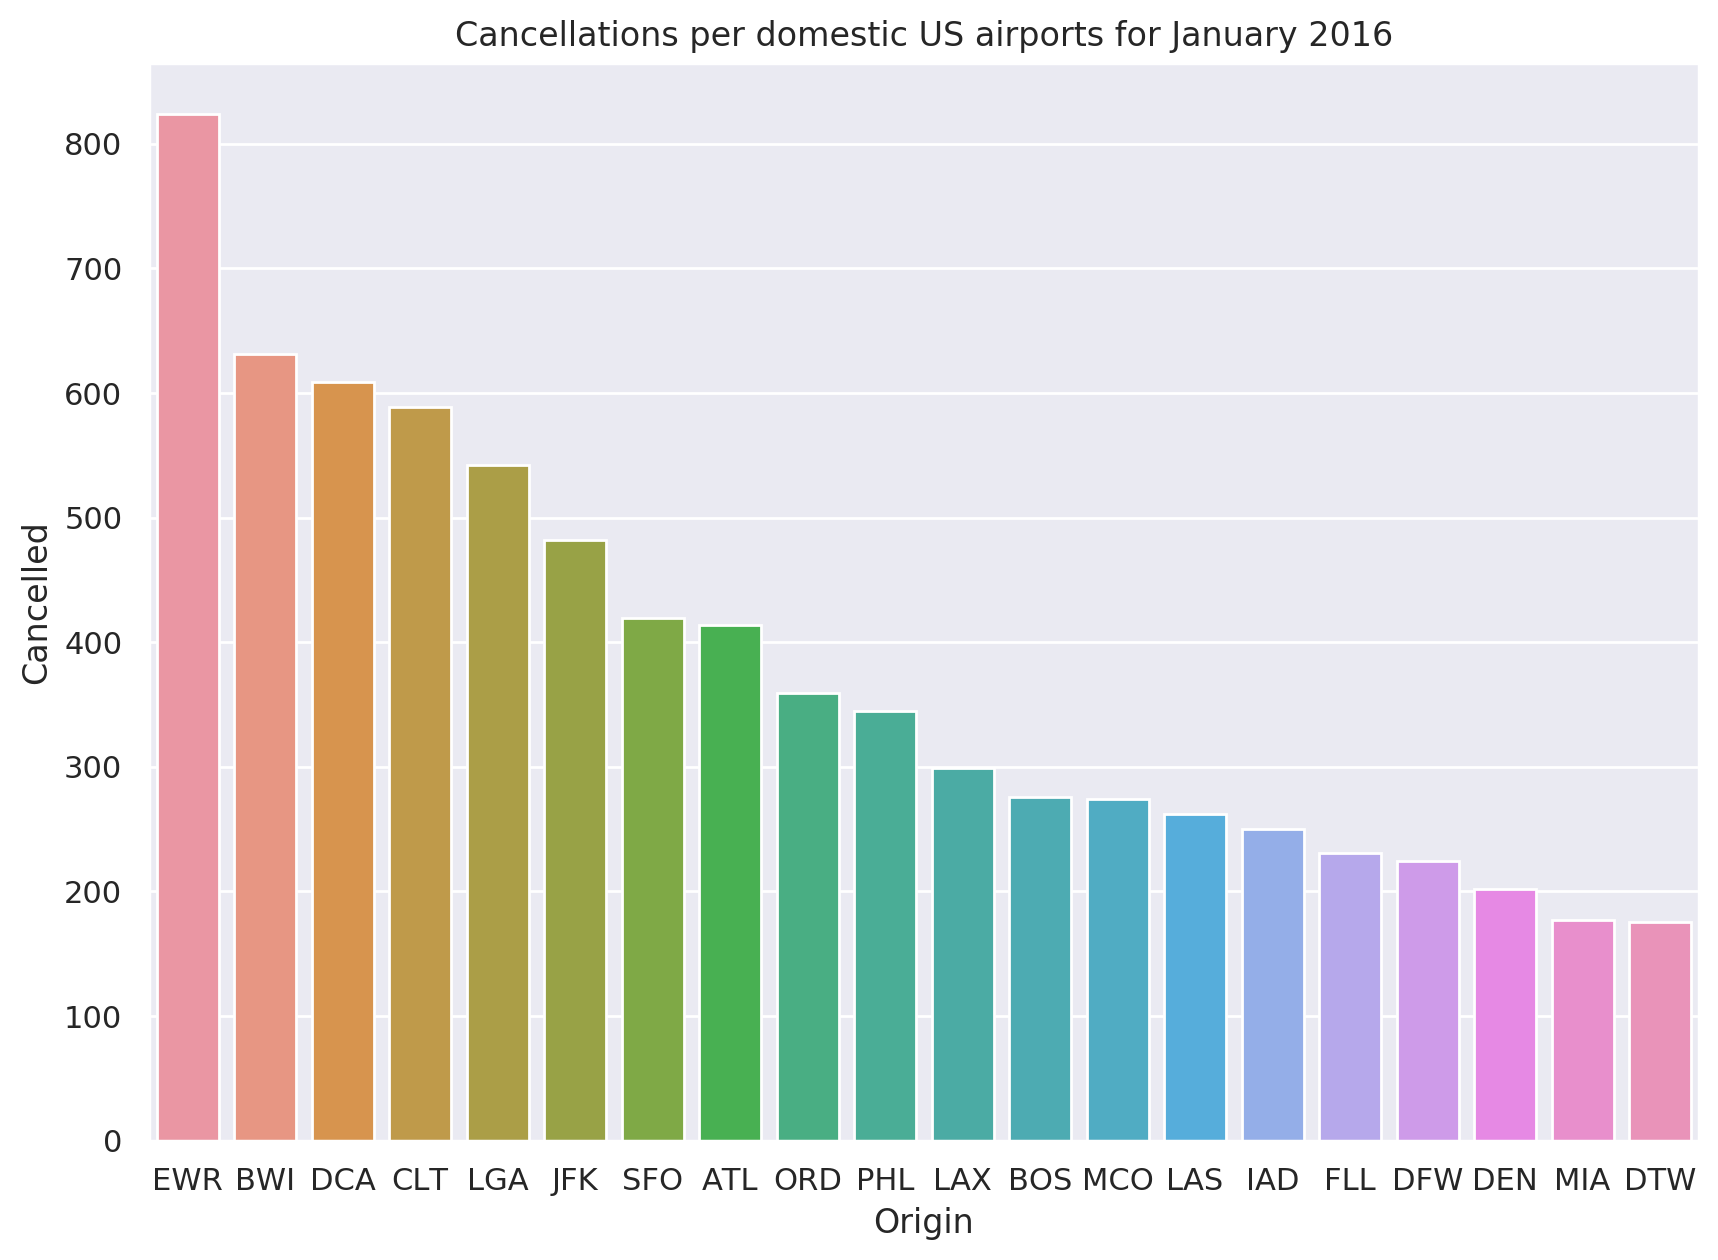

In [19]:
g_bar=sns.barplot(x="Origin", y="Cancelled", data=dff_airportOrigin.iloc[0:20])
g_bar.set_title("Cancellations per domestic US airports for January 2016")


### How do Canceled Flights look like for JFK?

In [29]:
flights_df.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,0,2016,1,1,6,3,2016-01-06,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,1,1,7,4,2016-01-07,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016,1,1,8,5,2016-01-08,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016,1,1,9,6,2016-01-09,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016,1,1,10,7,2016-01-10,AA,19805,AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Checking the class balance on our target variable 'Cancelled' as cancelled fllights
dff_Origin_JFK = flights_df[flights_df["Origin"]=="JFK"].reset_index()
#data[data['Value'] == True]
dff_Origin_JFK.head()


,index,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,88,88,2016,1,1,1,5,2016-01-01,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89,89,2016,1,1,2,6,2016-01-02,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,90,2016,1,1,3,7,2016-01-03,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91,91,2016,1,1,4,1,2016-01-04,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,92,2016,1,1,5,2,2016-01-05,AA,19805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Percentage of canceled flights from total flights:
x=dff_Origin_JFK.shape
xx=dff_Origin_JFK['Cancelled'].sum()
xx/x[0]

0.06004734022673477

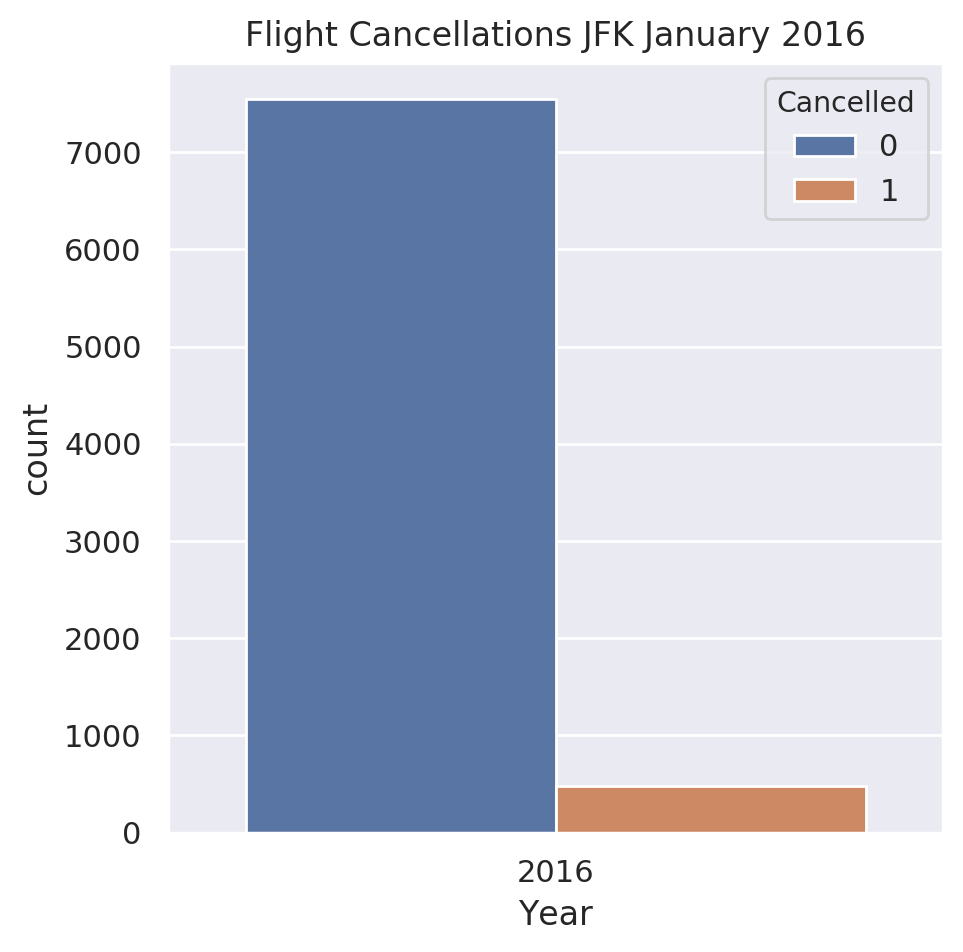

In [75]:
sns.set(rc={'figure.figsize':(5,5)})

sns.countplot(data=dff_Origin_JFK, x="Year", hue="Cancelled").set_title("Flight Cancellations JFK January 2016")
plt.show()

6% of flights in January were canceled at JFK

### What is the most common weather type and severity in the weather dataset for January 2016 US Airports?

In [89]:
weather_df= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/WeatherUS_2016/WeatherUS_2016.csv")
weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [97]:
weather_df.rename(columns={'StartTime(UTC)':'StartTime'}, inplace=True)
weather_df.rename(columns={'EndTime(UTC)':'EndTime'}, inplace=True)


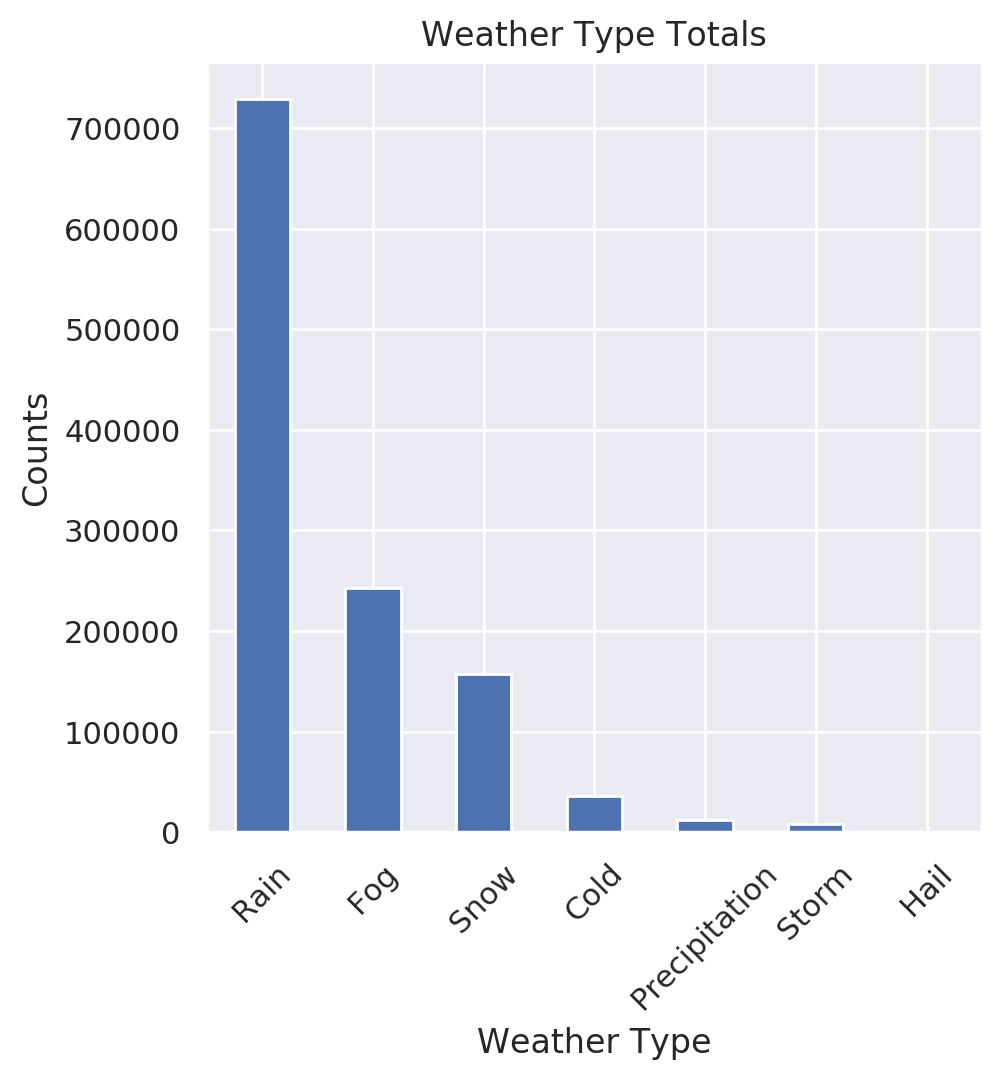

In [91]:
weather_df['Type'].value_counts().plot(kind='bar')
plt.title('Weather Type Totals')
plt.xlabel('Weather Type')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

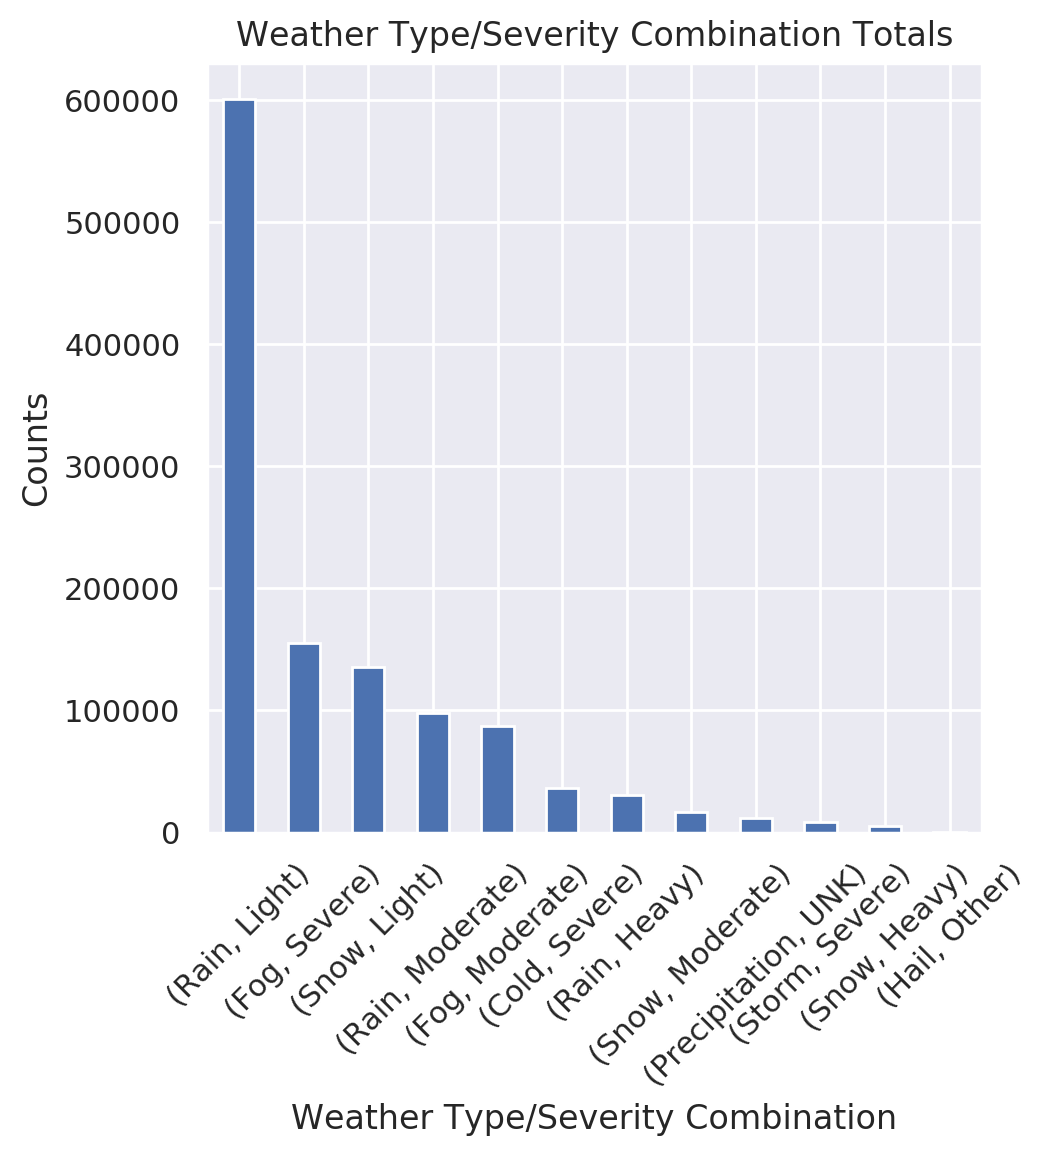

In [93]:
weather_df[['Type', 'Severity']].value_counts().plot(kind='bar')
plt.title('Weather Type/Severity Combination Totals')
plt.xlabel('Weather Type/Severity Combination')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

### What are the weather type/severity distributions for JFK in particular?

In [103]:
weather_JFK = weather_df[weather_df["AirportCode"]=="KJFK"].reset_index()


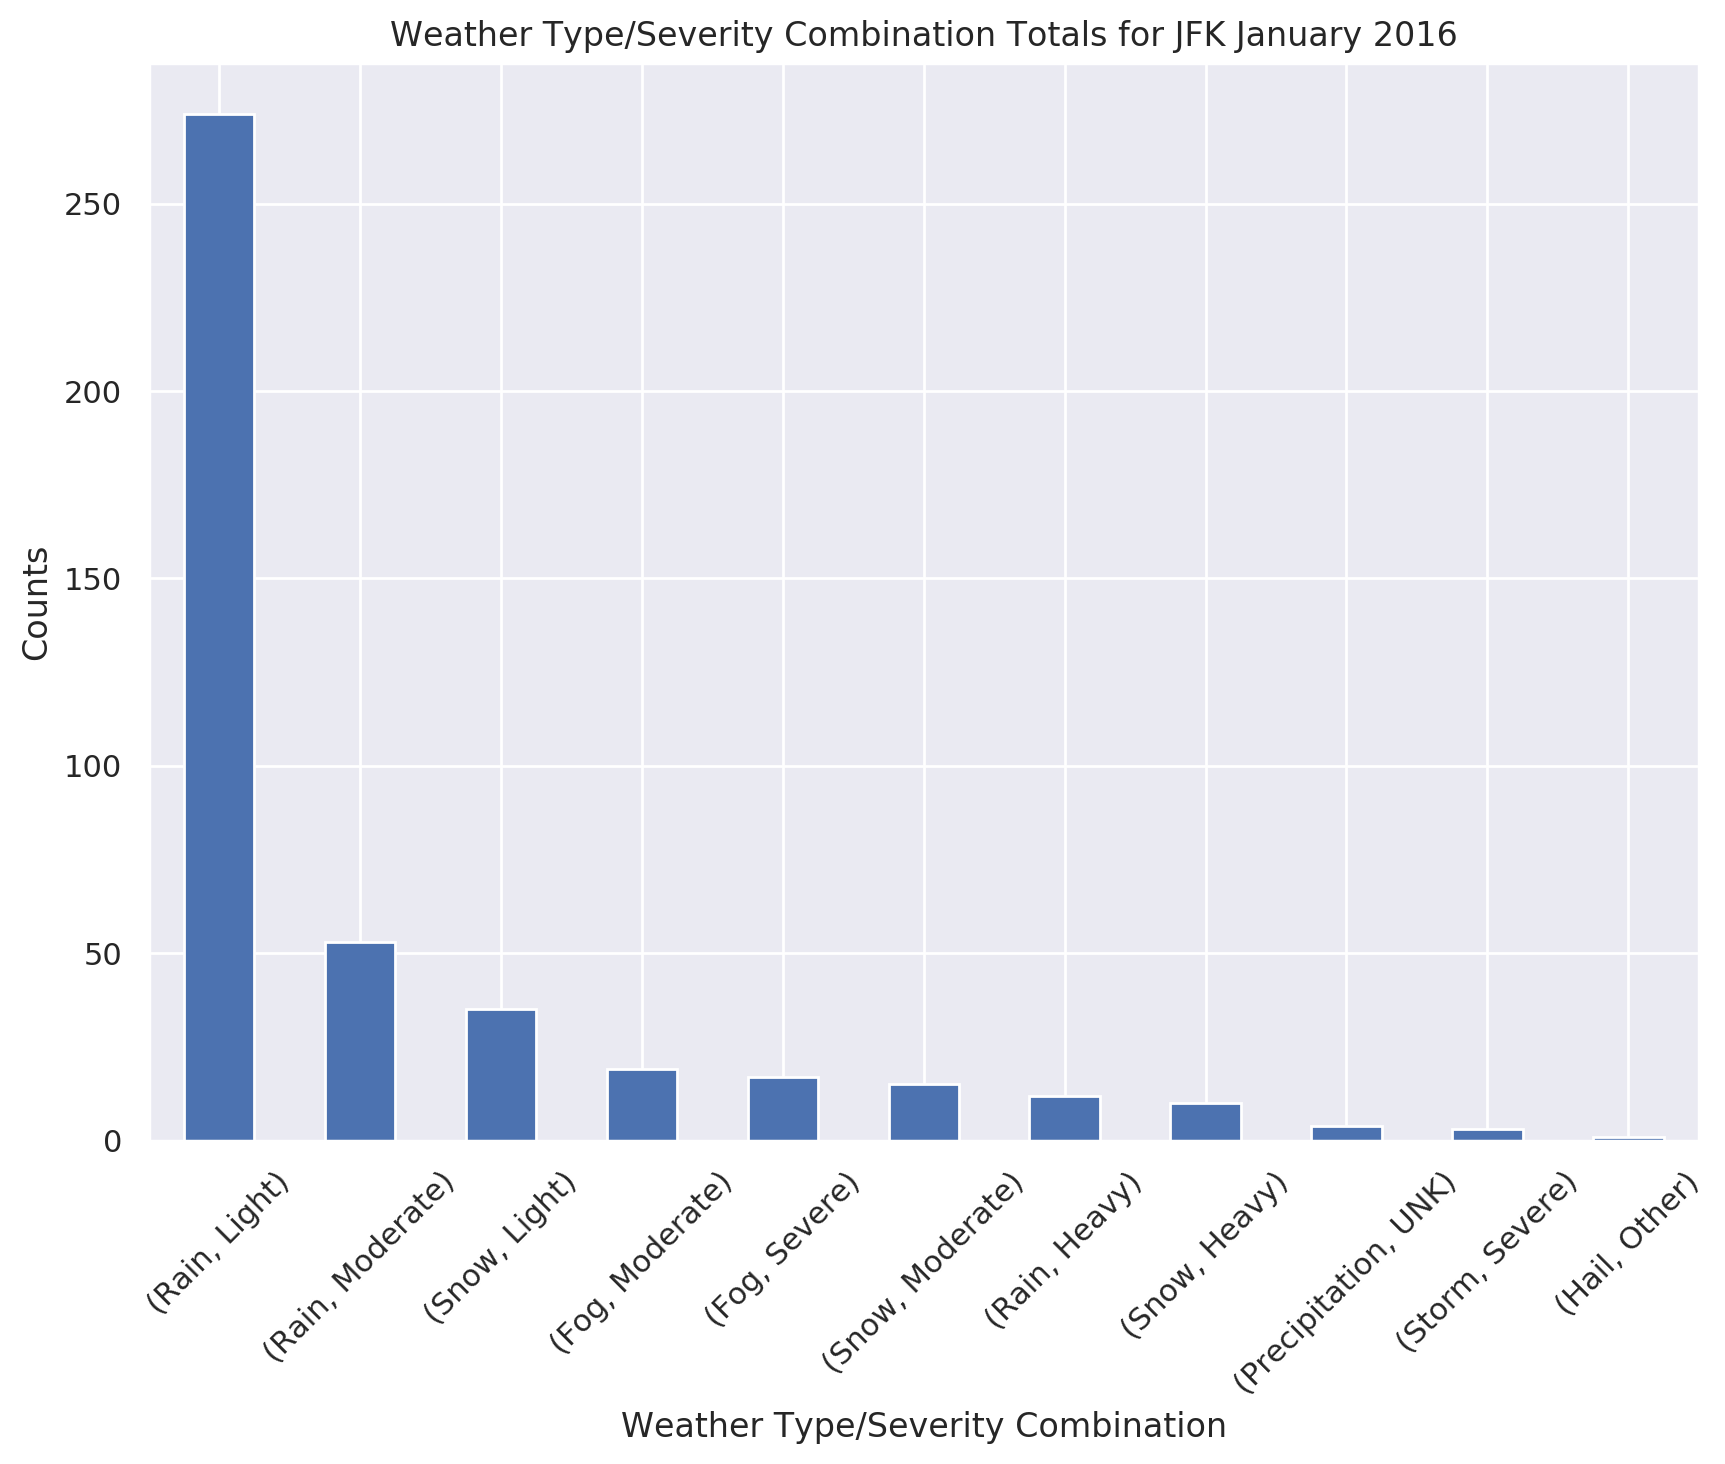

In [107]:
weather_JFK[['Type', 'Severity']].value_counts().plot(kind='bar')
plt.title('Weather Type/Severity Combination Totals for JFK January 2016')
plt.xlabel('Weather Type/Severity Combination')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

### What is the timeline of JFK weather conditions?

In [24]:
JFK_weather_data= pd.read_csv("s3://sagemaker-us-east-1-993410942383/content-project/airline_data/JFK_weather/JFK_weather_Jan_2016.csv")

In [25]:
JFK_weather_data['Precipitation']=JFK_weather_data['Precipitation'].replace(['T'], 0.0001)
JFK_weather_data['Snow_Depth']=JFK_weather_data['Snow_Depth'].replace(['T'], 0.0001)
JFK_weather_data['New_Snow']=JFK_weather_data['New_Snow'].replace(['T'], 0.0001)

In [26]:
JFK_weather_data.head(20)

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,1/1/2016,44.0,36.0,40,5.4,25,0,0,0,0
1,1/2/2016,41.0,34.0,37.5,3.1,27,0,0,0,0
2,1/3/2016,48.0,35.0,41.5,7.3,23,0,0,0,0
3,1/4/2016,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,1/5/2016,29.0,12.0,20.5,-13.4,44,0,0,0,0
5,1/6/2016,40.0,21.0,30.5,-3.2,34,0,0,0,0
6,1/7/2016,46.0,27.0,36.5,3,28,0,0,0,0
7,1/8/2016,47.0,32.0,39.5,6.1,25,0,0,0,0
8,1/9/2016,53.0,40.0,46.5,13.3,18,0,0.02,0,0
9,1/10/2016,58.0,41.0,49.5,16.4,15,0,1.28,0,0


In [14]:
JFK_weather_data.iloc[0:30].head()

,Date,MaxTemp,MinTemp,AvgTemp,DepTemp,HDD,CDD,Precipitation,New_Snow,Snow_Depth
0,1/1/2016,44.0,36.0,40,5.4,25,0,0,0,0
1,1/2/2016,41.0,34.0,37.5,3.1,27,0,0,0,0
2,1/3/2016,48.0,35.0,41.5,7.3,23,0,0,0,0
3,1/4/2016,38.0,15.0,26.5,-7.5,38,0,0,0,0
4,1/5/2016,29.0,12.0,20.5,-13.4,44,0,0,0,0


[Text(0, 0, '01/01'),
 Text(0, 0, '01/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '01/04'),
 Text(0, 0, '01/05'),
 Text(0, 0, '01/06'),
 Text(0, 0, '01/07'),
 Text(0, 0, '01/08'),
 Text(0, 0, '01/09'),
 Text(0, 0, '01/10'),
 Text(0, 0, '01/11'),
 Text(0, 0, '01/12'),
 Text(0, 0, '01/13'),
 Text(0, 0, '01/14'),
 Text(0, 0, '01/15'),
 Text(0, 0, '01/16'),
 Text(0, 0, '01/17'),
 Text(0, 0, '01/18'),
 Text(0, 0, '01/19'),
 Text(0, 0, '01/20'),
 Text(0, 0, '01/21'),
 Text(0, 0, '01/22'),
 Text(0, 0, '01/23'),
 Text(0, 0, '01/24'),
 Text(0, 0, '01/25'),
 Text(0, 0, '01/26'),
 Text(0, 0, '01/27'),
 Text(0, 0, '01/28'),
 Text(0, 0, '01/29'),
 Text(0, 0, '01/30'),
 Text(0, 0, '01/31')]

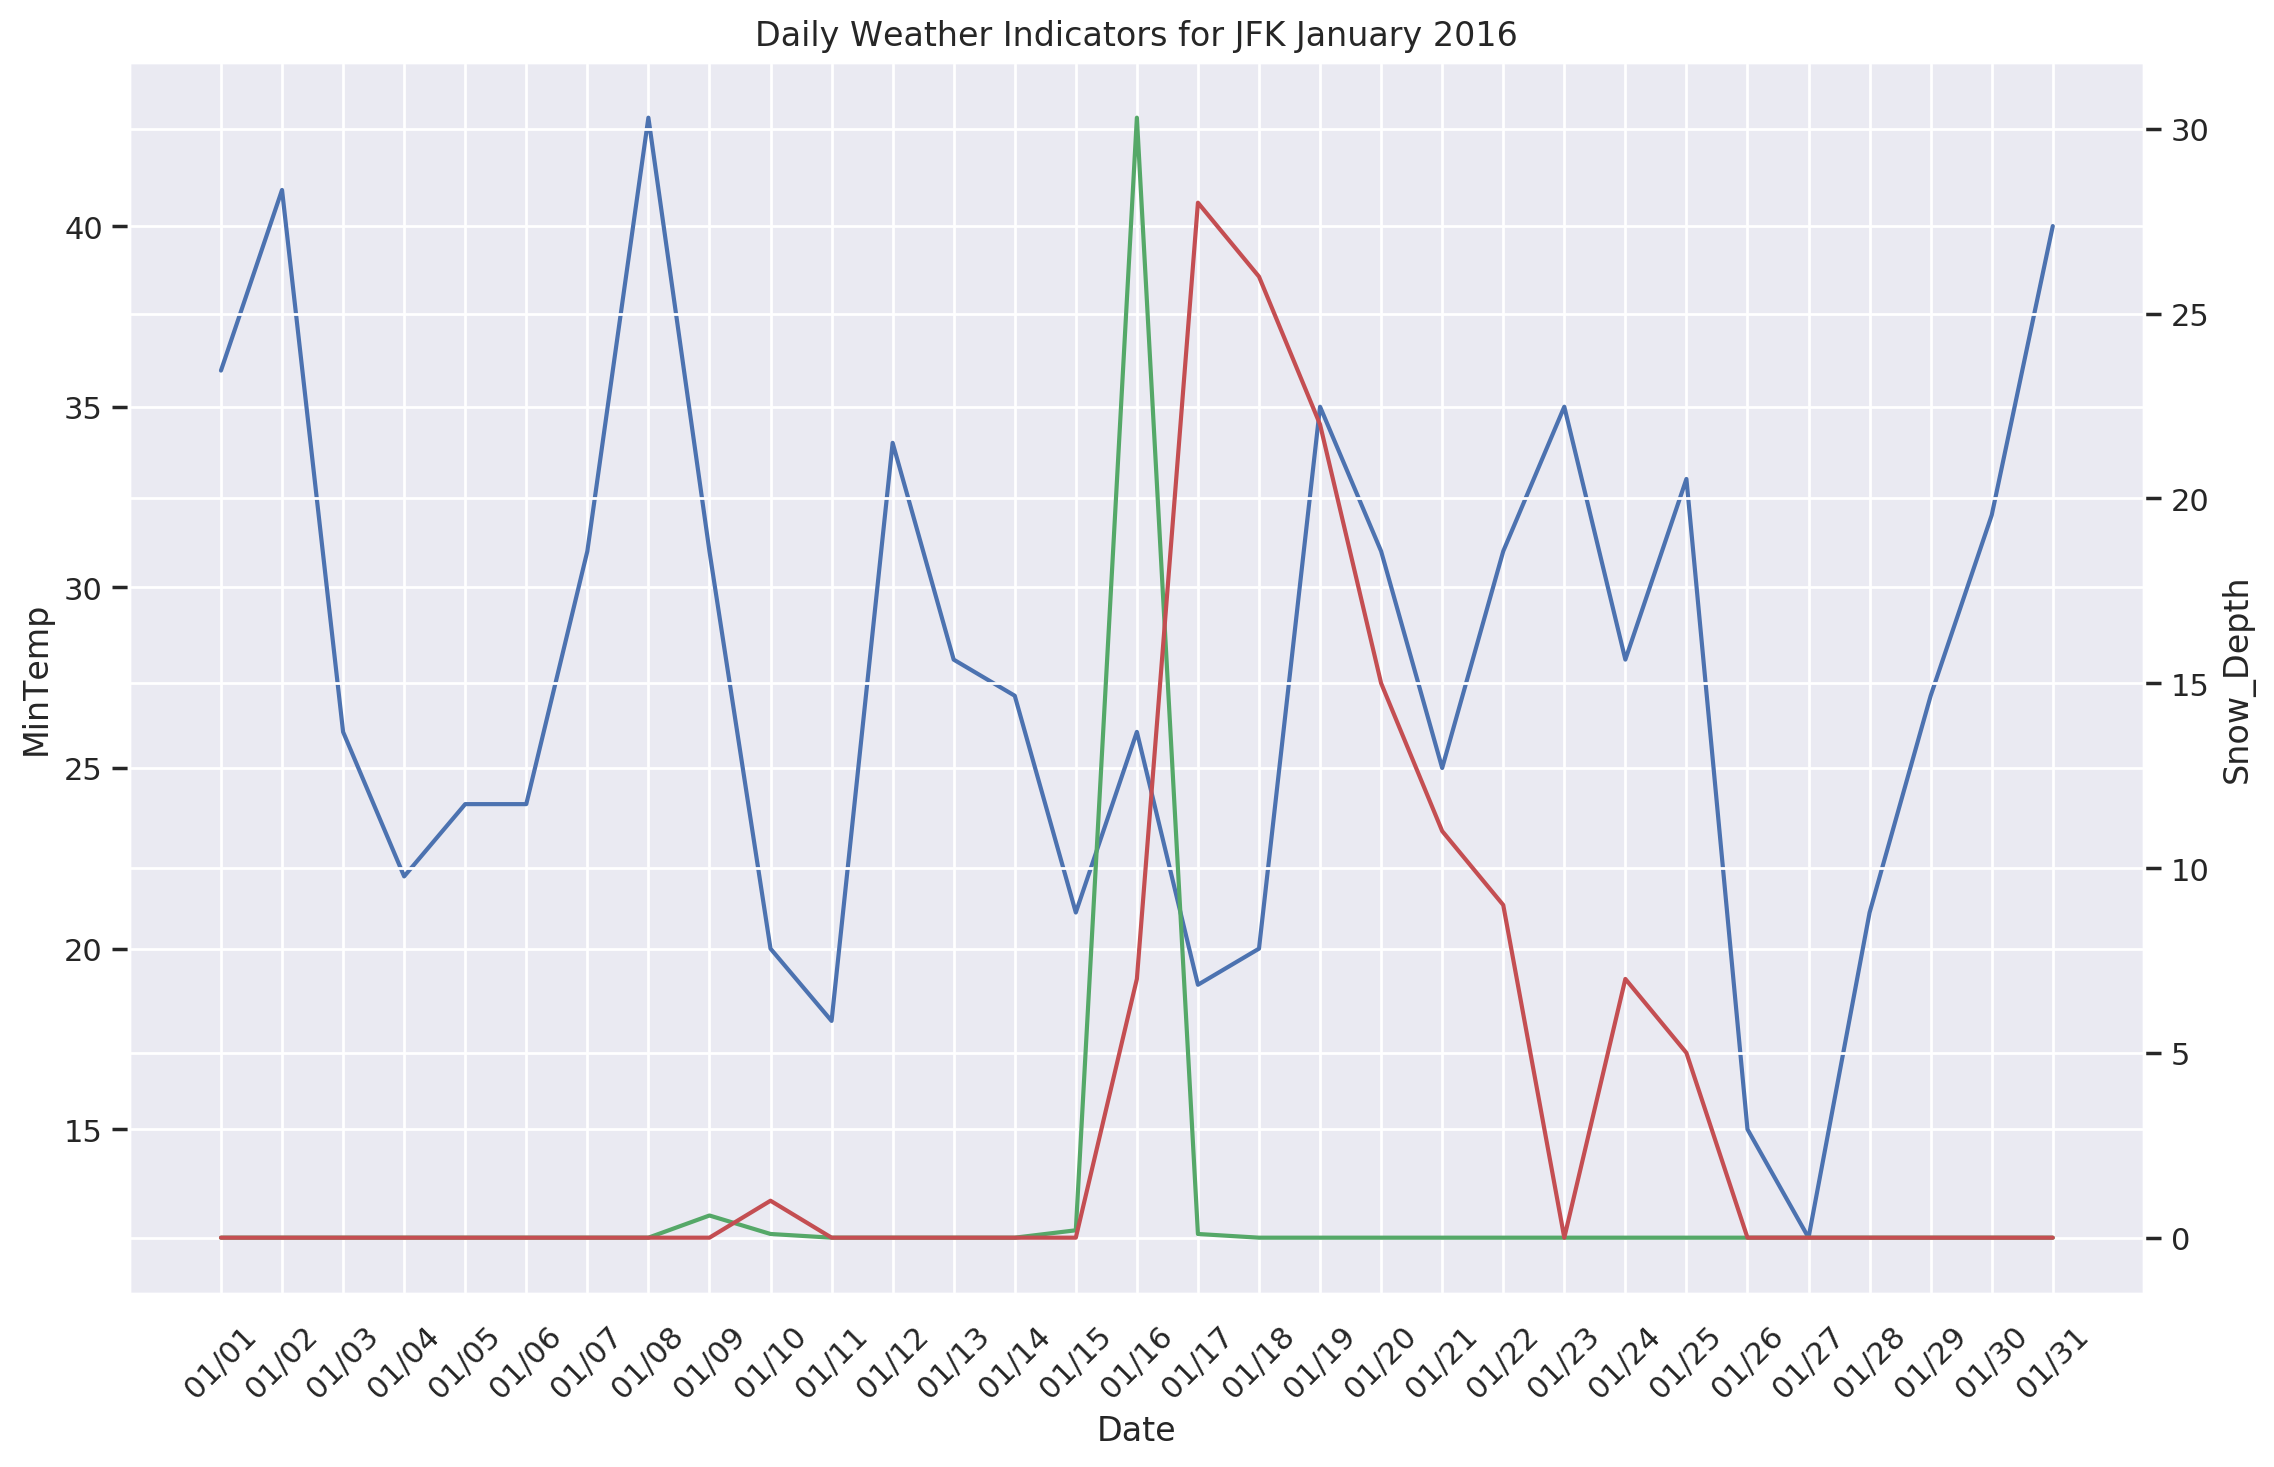

In [34]:
sns.set(rc={'figure.figsize':(10,9)})

fig, ax1 = plt.subplots(figsize=(13, 8))
ax1.set_title("Daily Weather Indicators for JFK January 2016")
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

#ax2.set(ylim=(0, y2_limit))
g1 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "MinTemp", ax = ax1, color = 'b') # plots the first set
g2 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "New_Snow", ax = ax2, color = 'g') # plots the second set 
g2 = sns.lineplot(data = JFK_weather_data.iloc[0:31], x = "Date", y = "Snow_Depth", ax = ax2, color = 'r') # plots the second set 

g1.set_xticklabels(labels=["01/01","01/02","01/03","01/04","01/05",
                          "01/06","01/07","01/08","01/09","01/10","01/11",
                          "01/12","01/13","01/14","01/15","01/16","01/17",
                          "01/18","01/19","01/20","01/21","01/22","01/23",
                          "01/24","01/25","01/26","01/27","01/28","01/29",
                          "01/30","01/31"], rotation=45)

#g3 = sns.lineplot(data = df, x = x1, y = y3, ax = ax3, color = y3_color)
